In [1]:
import os

from jax.experimental.pallas.ops.tpu.example_kernel import double

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


import jax.numpy as jnp
import numpy as np
import plotly.io as pio
pio.renderers.default = "browser"

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp

import cbvf_reachability as cbvf

from dyn_sys.MzNonlinearCar import MzNonlinearCar
from controllers.CBVF_QP import CBVFQPController, find_safe_entry_time_efficient
from controllers.CBVFInterpolator import CBVFInterpolator
from utils.animator import create_trajectory_animation



In [2]:
car_params = {'m': 1430, 'Vx': 30.0, 'Lf': 1.05, 'Lr': 1.61, 'Iz': 2059.2, 'mu': 1.0, 'Mz': 1e4 * 1.5,
                               'Cf': 9 * 10e3, 'Cr': 10 * 10e3}
dynamics = MzNonlinearCar(car_params=car_params)

# limits of the grid in degrees
x1_lim = 250
x2_lim = 90

x1_lim = x1_lim * jnp.pi / 180
x2_lim = x2_lim * jnp.pi / 180

grid = cbvf.Grid.from_lattice_parameters_and_boundary_conditions(cbvf.sets.Box(np.array([-x1_lim, -x2_lim]),
                                                                           np.array([x1_lim, x2_lim])),
                                                                           (300, 300))
values_vi = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 5 * jnp.pi / 180  # radius in radians
values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 5 * jnp.pi / 180  # radius in radians
initial_values = values_vi.copy()

solver_settings = cbvf.SolverSettings.with_accuracy(
    "very_high",
    hamiltonian_postprocessor=cbvf.solver.identity,
)



times = np.linspace(0, -0.25, 2500)

In [3]:
# time = 0.
# target_time = -0.3
# solver_settings = cbvf.SolverSettings.with_accuracy("cbvf",
#                                                   hamiltonian_postprocessor=cbvf.solver.identity,
#                                                   gamma=5)
# target_values_vi = cbvf.step_cbvf(solver_settings, dynamics, grid, time, values_vi, target_time, initial_values)
# solver_settings = cbvf.SolverSettings.with_accuracy("very_high",
#                                                   hamiltonian_postprocessor=cbvf.solver.backwards_reachable_tube)
# target_values = cbvf.step(solver_settings, dynamics, grid, time, values, target_time)

In [4]:
solver_settings = cbvf.SolverSettings.with_accuracy("cbvf",
                                                  hamiltonian_postprocessor=cbvf.solver.identity,
                                                  gamma=0.0)
target_values_vi = cbvf.solve_cbvf(solver_settings, dynamics, grid, times, values, initial_values)
# solver_settings = cbvf.SolverSettings.with_accuracy(
#     "very_high",
#     hamiltonian_postprocessor=cbvf.solver.backwards_reachable_tube,
# )
# target_values = cbvf.solve(solver_settings, dynamics, grid, times, initial_values)

2025-07-09 15:38:06.905946: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3023] Can't reduce memory use below 1.82GiB (1958918939 bytes) by rematerialization; only reduced to 2.51GiB (2699280016 bytes), down from 2.51GiB (2699280016 bytes) originally
100%|##########|  0.2500/0.25 [00:03<00:00, 12.19s/sim_s]


In [53]:
safe_controller = CBVFQPController(value_fn=CBVFInterpolator(grid, -target_values_vi, times, gamma=28800), gamma=28800, verbose=True)

In [56]:
# Simulation parameters
initial_state = jnp.array([-70 * (jnp.pi/180), 15 * (jnp.pi/180)])  # Initial state [yaw_rate, sideslip] in radians
sim_time = 1.2  # Total simulation time in seconds
dt = 0.001  # Time step for integration
u_ref_value = -50000  # Reference control (constant positive yaw moment)

# car_params = {'m': 1430, 'Vx': 60, 'Lf': 1.05, 'Lr': 1.61, 'Iz': 2059.2, 'mu': 1.0, 'Mz': 10e3 * 0.5,
#                                'Cf': 100 * 10e3, 'Cr': 3 * 10e3}
#
# dynamics = MzNonlinearCar(car_params=car_params)

# Initialize storage for trajectory
time_sim = np.arange(0, sim_time, dt)
trajectory = np.zeros((len(time_sim), 2))
controls = np.zeros(len(time_sim))
controls_ref = np.zeros(len(time_sim))
constrain_val = np.zeros(len(time_sim))
cbvf_values = np.zeros(len(time_sim))

# Set initial state
current_state = initial_state
trajectory[0] = current_state

# Simulation loop
for i, t in enumerate(time_sim[:-1]):
    # Compute reference control (constant max positive input)
    u_ref = u_ref_value #* np.sin(t * 1.5 * np.pi / sim_time)  # Example: sinusoidal reference control

    # Compute safe control using CBVF-QP
    u_safe, constrain_val[i] = safe_controller.compute_safe_control(
        state=current_state,
        time=t,
        u_ref=u_ref,
        u_prev=controls[i - 1] if i > 0 else 0.0,  # Previous control input
        dynamics=dynamics,
        u_max_mag=15000,
    )

    # u_safe = np.array([0])

    # Store controlcurrent_state
    controls[i] = u_safe
    controls_ref[i] = u_ref

    # Get CBVF value at current state
    gradient_time = find_safe_entry_time_efficient(safe_controller.cbvf, current_state, 0.0)
    cbvf_val, _, _ = safe_controller.cbvf.get_value_and_gradients(current_state, gradient_time)

    if cbvf_val < 0.0:
        print(f"Warning: CBVF value is negative at time {t:.3f}s: {cbvf_val:.4f}")
    cbvf_values[i] = cbvf_val

    # Integrate dynamics forward (simple Euler integration)
    state_dot = dynamics.open_loop_dynamics(current_state, t) + dynamics.control_jacobian(current_state, t) @ np.array([u_safe])
    current_state = current_state + dt * state_dot

    # Store next state
    if i < len(time_sim) - 1:
        trajectory[i + 1] = current_state

# Convert trajectory to degrees for visualization
trajectory_deg = trajectory * 180 / np.pi


print(f"Simulation completed. Final state: yaw_rate={trajectory_deg[-1, 0]:.2f} deg/s, sideslip={trajectory_deg[-1, 1]:.2f} deg")
print(f"Min CBVF value during trajectory: {np.min(cbvf_values[:-1]):.4f}")

Current state: [-1.2217305  0.2617994], time: 0.0, reference control: -50000
Gradient time for safe entry: -0.17727090836334536

=== CONSTRAINT FEASIBILITY ANALYSIS ===

1. Safety constraint: -9.034173e-05 * u <= 2.409377
   → u >= -26669.59

2. Control bounds:
   Lower bound: u >= -15000
   Upper bound: u <= 15000

=== FEASIBLE RANGES ===
Safety constraint allows: u ∈ [-26669.59, inf]
Control bounds allow:     u ∈ [-15000.00, 15000.00]

FEASIBLE REGION: u ∈ [-15000.00, 15000.00]
Optimal feasible control closest to u_ref=-50000: -15000.00

=== SAFETY VALUES AT KEY CONTROLS ===
At u_ref=-50000.00: safety =   6.926463 (SAFE)
At u_min=-15000.00: safety =   3.764503 (SAFE)
At u_max=15000.00: safety =   1.054251 (SAFE)
At u=0=    0.00: safety =   2.409377 (SAFE)

Current state: [-1.2292292  0.2614538], time: 0.001, reference control: -50000
Gradient time for safe entry: -0.17787114845938376

=== CONSTRAINT FEASIBILITY ANALYSIS ===

1. Safety constraint: -9.974054e-05 * u <= -0.339731
   → u

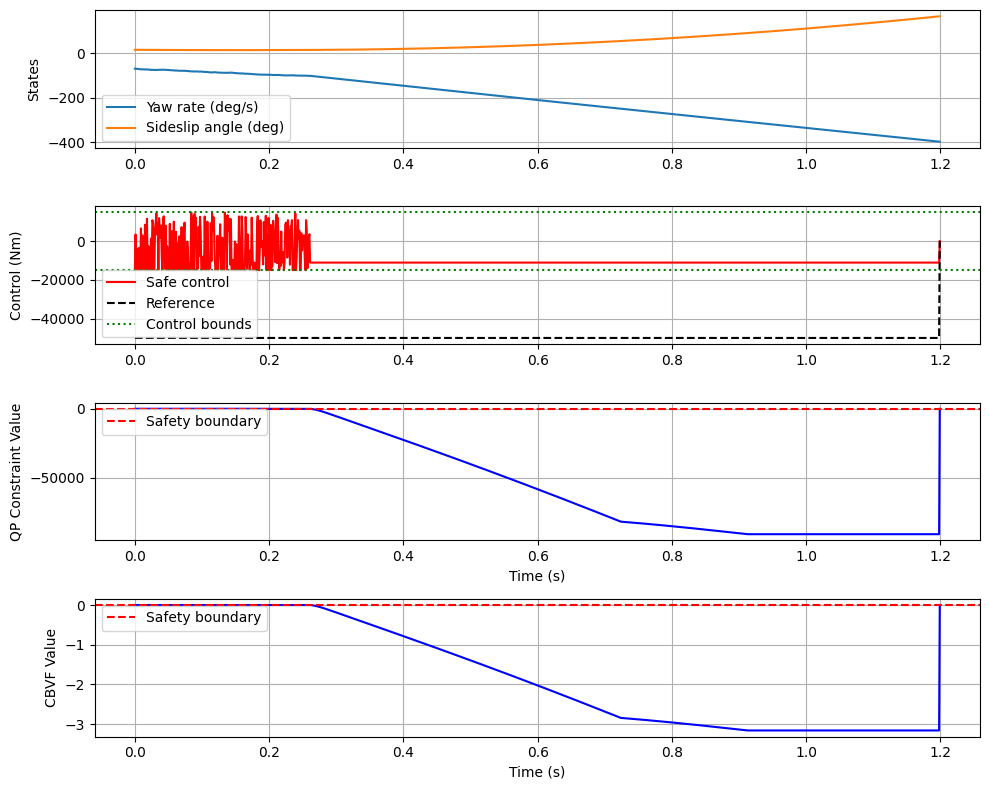

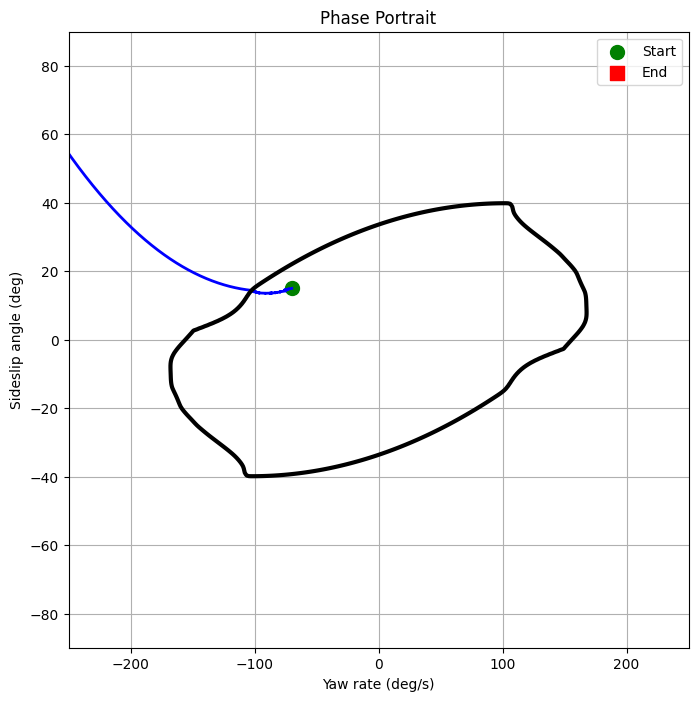

In [57]:
# Plot results
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

# State trajectory
axes[0].plot(time_sim, trajectory_deg[:, 0], label='Yaw rate (deg/s)')
axes[0].plot(time_sim, trajectory_deg[:, 1], label='Sideslip angle (deg)')
axes[0].set_ylabel('States')
axes[0].legend()
axes[0].grid(True)

# Control input
axes[1].plot(time_sim, controls, 'r-', label='Safe control')
axes[1].plot(time_sim, controls_ref, color='k', linestyle='--', label='Reference')
axes[1].axhline(y=dynamics.car_params['Mz'], color='g', linestyle=':', label='Control bounds')
axes[1].axhline(y=-dynamics.car_params['Mz'], color='g', linestyle=':')
axes[1].set_ylabel('Control (Nm)')
axes[1].legend()
axes[1].grid(True)

# QP Constrain value
axes[2].plot(time_sim, constrain_val, 'b-')
axes[2].axhline(y=0, color='r', linestyle='--', label='Safety boundary')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('QP Constraint Value')
axes[2].legend()
axes[2].grid(True)

# CVBF value
axes[3].plot(time_sim, cbvf_values, 'b-')
axes[3].axhline(y=0, color='r', linestyle='--', label='Safety boundary')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('CBVF Value')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

# Phase portrait
plt.figure(figsize=(8, 8))
plt.plot(trajectory_deg[:, 0], trajectory_deg[:, 1], 'b-', linewidth=2)
plt.scatter(trajectory_deg[0, 0], trajectory_deg[0, 1], color='g', s=100, marker='o', label='Start')
plt.scatter(trajectory_deg[-1, 0], trajectory_deg[-1, 1], color='r', s=100, marker='s', label='End')

# Add zero-level set contour if you want to visualize the safe boundary
# You would need to evaluate this at the appropriate time slice
plt.xlabel('Yaw rate (deg/s)')
plt.ylabel('Sideslip angle (deg)')
plt.title('Phase Portrait')
plt.legend()
plt.grid(True)
# plt.axis('equal')
plt.xlim(-x1_lim * 180 / jnp.pi, x1_lim * 180 / jnp.pi)
plt.ylim(-x2_lim * 180 / jnp.pi, x2_lim * 180 / jnp.pi)
plt.contour(grid.coordinate_vectors[0] * 180 / jnp.pi,
            grid.coordinate_vectors[1] * 180 / jnp.pi,
            target_values_vi[-1, :, :].T,
            levels=0,
            colors="black",
            linewidths=3)
plt.show()

In [ ]:
animation = create_trajectory_animation(trajectory[:, 0], trajectory[:, 1], time_sim, car_params,
                                        grid_limits={'yaw_rate': [-x1_lim, x1_lim],
                                                     'side_slip': [-x2_lim, x2_lim]},)
animation.show()

In [ ]:
plot_time_index = len(times) // 2

In [ ]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [ ]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0] * 180 / jnp.pi, grid.coordinate_vectors[1] * 180 / jnp.pi, target_values_vi[399, :, :].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0] * 180 / jnp.pi,
            grid.coordinate_vectors[1] * 180 / jnp.pi,
            target_values_vi[399, :, :].T,
            levels=0,
            colors="black",
            linewidths=3)

In [ ]:
f = go.Figure(data=go.Surface(z=target_values[:, :].T,
                                         x=grid.coordinate_vectors[0],
                                         y=grid.coordinate_vectors[1],
                                         colorscale="Jet",
                                         contours={
                                             "z": {
                                                 "show": True,
                                                 "start": 0.00,
                                                 "end": 0.00,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title="Reachable Set for MzNonlinearCar (norm)",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value"),
                  width=800,
                  height=800,
                  xaxis=dict(range=[-x1_lim, x1_lim]),
                  yaxis=dict(range=[-x2_lim, x2_lim]),
                  scene_aspectmode='cube')
f.show()

In [ ]:
f = go.Figure(data=go.Surface(z=-target_values_vi[-1, :, :].T,
                                         x=grid.coordinate_vectors[0],
                                         y=grid.coordinate_vectors[1],
                                         colorscale="Jet",
                                         contours={
                                             "z": {
                                                 "show": True,
                                                 "start": 0.00,
                                                 "end": 0.00,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title="Reachable Set for MzNonlinearCar (Alt)",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value"),
                  width=800,
                  height=800,
                  xaxis=dict(range=[-x1_lim, x1_lim]),
                  yaxis=dict(range=[-x2_lim, x2_lim]),
                  scene_aspectmode='cube')
f.show()

In [ ]:
f = go.Figure(data=go.Surface(z=target_values_vi[:, :].T - target_values[:, :].T,
                                         x=grid.coordinate_vectors[0],
                                         y=grid.coordinate_vectors[1],
                                         colorscale="Jet",
                                         contours={
                                             "z": {
                                                 "show": True,
                                                 "start": 0.00,
                                                 "end": 0.00,
                                                 "size": 1
                                             }
                                         }))
f.update_layout(title="Difference in sets",
                  scene=dict(xaxis_title="x1",
                             yaxis_title="x2",
                             zaxis_title="value"),
                  width=800,
                  height=800,
                  xaxis=dict(range=[-x1_lim, x1_lim]),
                  yaxis=dict(range=[-x2_lim, x2_lim]),
                  scene_aspectmode='cube')
f.show()